# 0. Imports

In [2]:
# %pip install ml_collections
# %pip install flax
# %pip install bayesian-optimization
# %pip install -qq git+https://github.com/probml/rebayes.git
# %pip install jaxtyping
# %pip install jax-tqdm
# %pip install dynamax
# %pip install jax-dataloader
# %pip install avalanche-lib

In [78]:
import pickle

from jaxtyping import Float, Array
from typing import Callable, NamedTuple, Union, Tuple, Any
from functools import partial
import chex
import optax
import jax
import jax.numpy as jnp
import jax.random as jr
from jax import lax, jacfwd, vmap, grad, jit
from jax.tree_util import tree_map, tree_reduce
import flax
import flax.linen as nn
from flax.training.train_state import TrainState
from tensorflow_probability.substrates.jax.distributions import MultivariateNormalFullCovariance as MVN
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from jax.flatten_util import ravel_pytree
from dataclasses import dataclass

from itertools import cycle

import torch
import numpy as np
from torch.utils.data import TensorDataset, DataLoader
from torchvision.transforms import ToTensor
from bayes_opt import BayesianOptimization
from tqdm import trange

import jax_dataloader.core as jdl

from rebayes.base import *
from rebayes.low_rank_filter.lofi import LoFiParams, RebayesLoFi, LoFiBel
from rebayes.extended_kalman_filter.ekf import RebayesEKF
from rebayes.utils.utils import *
from rebayes.utils.avalanche import *
from rebayes.sgd_filter import sgd
from rebayes.sgd_filter import replay_sgd as rsgd
from demos.showdown.nonstationary import hparam_tune_clf as hpt
from avalanche.benchmarks.classic import SplitMNIST

# 1. Load Dataset

In [2]:
def load_split_mnist_dataset(n_tasks=5, ntrain_per_task=200, nval_per_batch=500, ntest_per_task=1_000, key=0):
    dataset = SplitMNIST(n_experiences=n_tasks, seed=0, return_task_id=True,
                         class_ids_from_zero_in_each_exp=True, fixed_class_order=range(10))
    nvaltest_per_task = nval_per_batch + ntest_per_task
    Xtr, Ytr, Xte, Yte =  make_avalanche_data(dataset, ntrain_per_task, ntrain_per_task, nvaltest_per_task, key=key)
    Xtr, Xte = Xtr.reshape(-1, 1, 28, 28, 1), Xte.reshape(-1, 1, 28, 28, 1)
    Xte_batches, Yte_batches = jnp.split(Xte, n_tasks), jnp.split(Yte, n_tasks)
    Xval_sets, Yval_sets = [batch[:nval_per_batch] for batch in Xte_batches], [batch[:nval_per_batch] for batch in Yte_batches]
    Xte_sets, Yte_sets = [batch[nval_per_batch:] for batch in Xte_batches], [batch[nval_per_batch:] for batch in Yte_batches]

    Xval, Yval = jnp.concatenate(Xval_sets), jnp.concatenate(Yval_sets)
    Xte, Yte = jnp.concatenate(Xte_sets), jnp.concatenate(Yte_sets)

    Xtr_flat = flatten_batch(Xtr)

    return (Xtr, Ytr), (Xval, Yval), (Xte, Yte)

In [137]:
n_experiences = 5
ntrain_per_dist, ntrain_per_batch, nval_per_batch, ntest_per_batch = 200, 200, 500, 1_000

(Xtr, Ytr), (Xval, Yval), (Xte, Yte) = load_split_mnist_dataset(
    n_experiences, ntrain_per_batch, nval_per_batch, ntest_per_batch, 100
)

In [138]:
train, val = (Xtr, Ytr), (Xval, Yval)

In [5]:
train_ds = jdl.Dataset(Xtr, Ytr)
train_loader = jdl.DataLoaderJax(train_ds, batch_size=ntrain_per_batch, shuffle=False, drop_last=False)
train_iter = iter(train_loader)

test_ds = jdl.Dataset(Xte, Yte)
test_loader = jdl.DataLoaderJax(test_ds, batch_size=nval_per_batch, shuffle=False, drop_last=False)
test_iter = iter(test_loader)

for b in range(len(train_iter)): 
    (Xb,Yb) = next(train_iter)
    print('batch ', b, Xb.shape, Yb.shape)
    (Xb,Yb) = next(test_iter)
    print('test batch ', b, Xb.shape, Yb.shape)

batch  0 (200, 1, 28, 28, 1) (200, 1)
test batch  0 (500, 1, 28, 28, 1) (500, 1)
batch  1 (200, 1, 28, 28, 1) (200, 1)
test batch  1 (500, 1, 28, 28, 1) (500, 1)
batch  2 (200, 1, 28, 28, 1) (200, 1)
test batch  2 (500, 1, 28, 28, 1) (500, 1)
batch  3 (200, 1, 28, 28, 1) (200, 1)
test batch  3 (500, 1, 28, 28, 1) (500, 1)
batch  4 (200, 1, 28, 28, 1) (200, 1)
test batch  4 (500, 1, 28, 28, 1) (500, 1)


In [6]:
def plot_batch(Xb, Yb, ttl=None):
    figure = plt.figure(figsize=(8, 8))
    cols, rows = 3, 3
    for i in range(1, cols * rows + 1):
        #sample_idx = torch.randint(len(training_data), size=(1,)).item()
        sample_idx = i-1
        img = Xb[sample_idx]
        label = Yb[sample_idx]
        figure.add_subplot(rows, cols, i)
        plt.title(label)
        plt.axis("off")
        plt.imshow(img.squeeze(), cmap="gray")
    if ttl is not None: plt.suptitle(ttl)
    plt.show()

In [7]:
class RebayesSum(Rebayes):
    """The belief state is the sum of all the input X_t values."""
    def __init__(
        self,
        params: RebayesParams,
        shape_in, 
        shape_out
    ):
        self.params = params
        self.shape_in = shape_in
        self.shape_out = shape_out

    def init_bel(self) -> Belief:
        bel = Belief(dummy = jnp.zeros(self.shape_in))
        return bel
    
    def update_state(
        self,
        bel: Belief,
        X: Float[Array, "input_dim"],
        Y: Float[Array, "obs_dim"]
    ) -> Belief:
        return Belief(dummy = bel.dummy + X)

In [8]:
# train_ds = jdl.Dataset(Xtr, Ytr)
# train_loader = jdl.DataLoaderJax(train_ds, batch_size=ntrain_per_batch, shuffle=False, drop_last=False)

# test_ds = jdl.Dataset(Xte, Yte)
# test_loader = jdl.DataLoaderJax(test_ds, batch_size=nval_per_batch, shuffle=False, drop_last=False)
# test_iter = iter(test_loader)

# def callback_dl(b, bel_pre, bel_post, batch, **kwargs):
#     Xtr, Ytr = batch
#     jax.debug.print("callback on batch {b}", b=b)
#     jax.debug.print("Xtr shape {x1}, Ytr shape {y1}", x1=Xtr.shape, y1=Ytr.shape)
#     Xte, Yte = next(test_iter)
#     jax.debug.print("Xte shape {x1}, Yte shape {y1}", x1=Xte.shape, y1=Yte.shape)
#     plot_batch(Xte, Yte, ttl='batch {:d}'.format(b))
#     return b

# shape_in = Xtr.shape[1:]
# shape_out = 1
# estimator = RebayesSum(make_rebayes_params(), shape_in, shape_out)

# bel, outputs = estimator.scan_dataloader(train_loader, callback=callback_dl)
# Xsum = jnp.sum(Xtr, axis=0)
# # assert(jnp.allclose(Xsum, bel.dummy, atol=1e-1))

# 2. Model Setup

In [9]:
class MLP(nn.Module):
    features: Sequence[int]

    @nn.compact
    def __call__(self, x):
        x = x.ravel()
        for feat in self.features[:-1]:
            x = nn.relu(nn.Dense(feat)(x))
        x = nn.Dense(self.features[-1])(x)
        return x

features = [400, 400, 1]
model = MLP(features)
params = model.init(jr.PRNGKey(0), jnp.ones([1, 28, 28, 1]).ravel())
flat_params, unflatten_fn = ravel_pytree(params)

# Define apply function
def apply(flat_params, x, model, unflatten_fn):
    return model.apply(unflatten_fn(flat_params), jnp.atleast_1d(x))

apply_fn = partial(apply, model=model, unflatten_fn=unflatten_fn)
print(f'flat_params.shape: {flat_params.shape}')

flat_params.shape: (474801,)


In [10]:
# class CNN(nn.Module):
#     """A simple CNN model."""
#     @nn.compact
#     def __call__(self, x):
#         x = nn.Conv(features=32, kernel_size=(3, 3))(x)
#         x = nn.relu(x)
#         x = nn.avg_pool(x, window_shape=(2, 2), strides=(2, 2))
#         x = nn.Conv(features=64, kernel_size=(3, 3))(x)
#         x = nn.relu(x)
#         x = nn.avg_pool(x, window_shape=(2, 2), strides=(2, 2))
#         x = x.reshape((x.shape[0], -1))  # flatten
#         x = nn.Dense(features=128)(x)
#         x = nn.relu(x)
#         x = nn.Dense(features=1)(x)
#         return x

# key = jr.PRNGKey(0)
# cnn_model = CNN()
# cnn_params = cnn_model.init(key, jnp.ones((1, 28, 28, 1)))
# flat_params, unflatten_fn = ravel_pytree(cnn_params)
# print(f'flat_params.shape: {flat_params.shape}')

# # Define apply function
# def apply(flat_params, x, model, unflatten_fn):
#     return model.apply(unflatten_fn(flat_params), jnp.atleast_1d(x))

# apply_fn = partial(apply, model=cnn_model, unflatten_fn=unflatten_fn)

In [11]:
sigmoid_fn = lambda w, x: jnp.clip(jax.nn.sigmoid(apply_fn(w, x)), 1e-4, 1-1e-4).ravel()
emission_mean_function = lambda w, x: sigmoid_fn(w, x)
emission_cov_function = lambda w, x: sigmoid_fn(w, x) * (1 - sigmoid_fn(w, x))

# 3. FDEKF

## 3.1 Hyperparam Tuning

To tune the hyperparameters, we maximize the average validation accuracy across all 5 tasks after training on the full training set.

In [12]:
pbounds={
    'log_init_cov': (-10, 0),
    'log_dynamics_weights': (-40, 0),
    'log_dynamics_cov': (-40, 0),
    'log_alpha': (-40, 0),
}
fcekf_model = 'fdekf'

In [13]:
def evaluate_accuracy(flat_params, apply_fn, X, y):
    """ Evaluate accuracy for given parameters and test set
    """
    @jit
    def evaluate_acc(image, label):
        image = image.reshape((1, 28, 28, 1))
        logits = apply_fn(flat_params, image).ravel()
        acc = jnp.mean(jnp.round(jax.nn.sigmoid(logits)) == label.ravel())
        
        return acc
    accs = vmap(evaluate_acc, (0, 0))(X, y).mean()
    return accs

def acc_callback(bel, *args, **kwargs):
    X_test, y_test, apply_fn = kwargs["X_test"], kwargs["y_test"], kwargs["apply_fn"]
    accuracy = evaluate_accuracy(bel.mean, apply_fn, X_test, y_test)
    
    result = {
        'test': accuracy,
    }
    
    return result

def ll_callback(bel, *args, **kwargs):
    X_test, y_test = kwargs["X_test"], kwargs["y_test"]
    apply_fn = kwargs["apply_fn"]
    
    logits = vmap(jit(apply_fn), (None, 0))(bel.mean, X_test).ravel()
    nll = jnp.mean(jit(optax.sigmoid_binary_cross_entropy)(logits, y_test.ravel()))
    if jnp.isnan(nll):
        nll = 1e8
    result = -nll
    
    res = {
        "test": result,
    }
    return res

In [14]:
fdekf_optimizer, apply_fn, n_feats = hpt.create_optimizer(
    model, pbounds, 314, train, val, emission_mean_function, emission_cov_function,
    ll_callback, 'fdekf',
)

In [ ]:
%%time
fdekf_optimizer.maximize(
    init_points=50,
    n_iter=50,
)

|   iter    |  target   | log_alpha | log_dy... | log_dy... | log_in... |
-------------------------------------------------------------------------
| 1         | -210.3    | -3.325    | -16.46    | -29.4     | -2.168    |
| 2         | -224.1    | -3.28     | -6.906    | -10.88    | -7.395    |
| 3         | -166.8    | -3.529    | -29.57    | -9.345    | -7.385    |
| 4         | -0.692    | -35.11    | -24.56    | -6.397    | -7.218    |
| 5         | -1.281    | -37.2     | -14.68    | -16.61    | -4.188    |
| 6         | -0.7912   | -12.91    | -12.51    | -22.44    | -6.791    |
| 7         | -0.6921   | -17.18    | -20.81    | -5.557    | -1.652    |
| 8         | -1.075    | -35.77    | -37.58    | -16.12    | -2.076    |
| 9         | -0.5135   | -30.95    | -18.59    | -34.56    | -6.278    |
| 10        | -0.4738   | -33.92    | -22.81    | -8.292    | -5.93     |
| 11        | -9.449e+0 | -32.89    | -3.63     | -18.19    | -8.995    |
| 12        | -1.315e+0 | -11.25    | 

## 3.2 Test Set Accuracy

In [14]:
fdekf_hparams = {
    'initial_covariance': 0.0010313810518482653,
    'dynamics_weights': 0.9999999999999791,
    'dynamics_covariance': 2.1137513659049582e-14,
    'dynamics_covariance_inflation_factor': 6.010309295351233e-10
}

In [15]:
# fdekf_hparams = hpt.get_best_params(fdekf_optimizer)
fdekf_estimator = hpt.build_estimator(flat_params, fdekf_hparams, emission_mean_function,
                                      emission_cov_function, method="fdekf")

In [16]:
fdekf_hparams

{'initial_covariance': 0.0010313810518482653,
 'dynamics_weights': 0.9999999999999791,
 'dynamics_covariance': 2.1137513659049582e-14,
 'dynamics_covariance_inflation_factor': 6.010309295351233e-10}

In [17]:
def test_acc_callback(bel, pred_obs, t, x, y, bel_pred, i, **kwargs):
    X_test, y_test = kwargs["X_test"], kwargs["y_test"]
    ntrain_per_batch, ntest_per_batch = kwargs["ntrain_per_batch"], kwargs["ntest_per_batch"]
    prev_test_batch, curr_test_batch = i*ntest_per_batch, (i+1)*ntest_per_batch
    curr_X_test, curr_y_test = X_test[prev_test_batch:curr_test_batch], y_test[prev_test_batch:curr_test_batch]
    cum_X_test, cum_y_test = X_test[:curr_test_batch], y_test[:curr_test_batch]
    apply_fn = kwargs["apply_fn"]
    
    overall_accuracy = evaluate_accuracy(bel.mean, apply_fn, cum_X_test, cum_y_test)
    current_accuracy = evaluate_accuracy(bel.mean, apply_fn, curr_X_test, curr_y_test)
    task1_accuracy = evaluate_accuracy(bel.mean, apply_fn, X_test[:ntest_per_batch], y_test[:ntest_per_batch])
    result = {
        'overall': overall_accuracy,
        'current': current_accuracy,
        'task1': task1_accuracy,
    }
    return result

In [44]:
def evaluate_model(estimator, n_iter=10, bel=None):
    overall_accs, current_accs, task1_accs = [], [], []
    for i in trange(n_iter):
        (Xtr, Ytr), _, (Xte, Yte) = load_split_mnist_dataset(key=i)
        train_ds = jdl.Dataset(Xtr, Ytr)
        train_loader = jdl.DataLoaderJax(train_ds, batch_size=ntrain_per_batch, shuffle=False, drop_last=False)

        test_kwargs = {
            'X_test': Xte,
            'y_test': Yte,
            'ntrain_per_batch': ntrain_per_batch,
            'ntest_per_batch': ntest_per_batch,
            'apply_fn': apply_fn,
        }

        _, accs = estimator.scan_dataloader(train_loader, callback=test_acc_callback, bel=bel, **test_kwargs)
        overall_accs.append(jnp.array([res['overall'] for res in accs]))
        current_accs.append(jnp.array([res['current'] for res in accs]))
        task1_accs.append(jnp.array([res['task1'] for res in accs]))
    
    overall_accs, current_accs, task1_accs = jnp.array(overall_accs), jnp.array(current_accs), jnp.array(task1_accs)
    overall_accs, current_accs, task1_accs = \
        overall_accs.reshape((n_iter, -1)), current_accs.reshape((n_iter, -1)), task1_accs.reshape((n_iter, -1))

    result = {
        'overall': overall_accs.mean(axis=0),
        'overall-std': overall_accs.std(axis=0),
        'current': current_accs.mean(axis=0),
        'current-std': current_accs.std(axis=0),
        'task1': task1_accs.mean(axis=0),
        'task1-std': task1_accs.std(axis=0),
    }
    
    return result


In [19]:
fdekf_res = evaluate_model(fdekf_estimator)

100%|██████████| 10/10 [04:54<00:00, 29.46s/it]


# 4. VDEKF

## 4.1 Hyperparam Tuning

In [24]:
vdekf_optimizer, apply_fn, n_feats = hpt.create_optimizer(
    model, pbounds, 314, train, val, emission_mean_function, emission_cov_function,
    ll_callback, 'vdekf',
)

In [25]:
%%time
vdekf_optimizer.maximize(
    init_points=50,
    n_iter=50,
)

|   iter    |  target   | log_alpha | log_dy... | log_dy... | log_in... |
-------------------------------------------------------------------------
| 1         | -51.89    | -3.325    | -16.46    | -29.4     | -2.168    |
| 2         | -3.727e+0 | -3.28     | -6.906    | -10.88    | -7.395    |
| 3         | -504.2    | -3.529    | -29.57    | -9.345    | -7.385    |
| 4         | -0.692    | -35.11    | -24.56    | -6.397    | -7.218    |
| 5         | -1.226    | -37.2     | -14.68    | -16.61    | -4.188    |
| 6         | -0.7865   | -12.91    | -12.51    | -22.44    | -6.791    |
| 7         | -0.6922   | -17.18    | -20.81    | -5.557    | -1.652    |
| 8         | -0.5697   | -35.77    | -37.58    | -16.12    | -2.076    |
| 9         | -0.5132   | -30.95    | -18.59    | -34.56    | -6.278    |
| 10        | -0.4736   | -33.92    | -22.81    | -8.292    | -5.93     |
| 11        | -5.002e+0 | -32.89    | -3.63     | -18.19    | -8.995    |
| 12        | -5.426e+0 | -11.25    | 

## 4.2 Test Set Accuracy

In [20]:
vdekf_hparams = {
    'initial_covariance': 0.0010313810518482653,
    'dynamics_weights': 0.9999999999999791,
    'dynamics_covariance': 2.1137513659049582e-14,
    'dynamics_covariance_inflation_factor': 6.010309295351233e-10
}

In [21]:
# vdekf_hparams = hpt.get_best_params(vdekf_optimizer)
vdekf_estimator = hpt.build_estimator(flat_params, vdekf_hparams, emission_mean_function,
                                      emission_cov_function, method="vdekf")

In [22]:
vdekf_hparams

{'initial_covariance': 0.0010313810518482653,
 'dynamics_weights': 0.9999999999999791,
 'dynamics_covariance': 2.1137513659049582e-14,
 'dynamics_covariance_inflation_factor': 6.010309295351233e-10}

In [23]:
vdekf_res = evaluate_model(vdekf_estimator)

100%|██████████| 10/10 [05:07<00:00, 30.77s/it]


# 5. LoFi (Rank 1)

## 5.1 Hyperparam Tuning

In [140]:
lofi_1_params = LoFiParams(
    memory_size=1,
    diagonal_covariance=False,
)

In [141]:
lofi_1_optimizer, apply_fn, n_feats = hpt.create_optimizer(
    model, pbounds, 314, train, val, emission_mean_function, emission_cov_function,
    ll_callback, 'lofi', params_lofi=lofi_1_params
)

In [142]:
%%time
lofi_1_optimizer.maximize(
    init_points=50,
    n_iter=50,
)

|   iter    |  target   | log_alpha | log_dy... | log_dy... | log_in... |
-------------------------------------------------------------------------
| 1         | -0.8143   | -3.325    | -16.46    | -29.4     | -2.168    |
| 2         | -0.8525   | -3.28     | -6.906    | -10.88    | -7.395    |
| 3         | -0.7306   | -3.529    | -29.57    | -9.345    | -7.385    |
| 4         | -0.6921   | -35.11    | -24.56    | -6.397    | -7.218    |
| 5         | -0.9718   | -37.2     | -14.68    | -16.61    | -4.188    |
| 6         | -0.678    | -12.91    | -12.51    | -22.44    | -6.791    |
| 7         | -0.692    | -17.18    | -20.81    | -5.557    | -1.652    |
| 8         | -2.009    | -35.77    | -37.58    | -16.12    | -2.076    |
| 9         | -0.4866   | -30.95    | -18.59    | -34.56    | -6.278    |
| 10        | -0.4604   | -33.92    | -22.81    | -8.292    | -5.93     |
| 11        | -3.02e+03 | -32.89    | -3.63     | -18.19    | -8.995    |
| 12        | -55.63    | -11.25    | 

## 5.2 Test Set Accuracy

In [25]:
lofi_1_hparams = {
    'initial_covariance': 0.0010313810518482653,
    'dynamics_weights': 0.9999999999999791,
    'dynamics_covariance': 2.1137513659049582e-14,
    'dynamics_covariance_inflation_factor': 6.010309295351233e-10
}

In [143]:
# lofi_1_hparams = hpt.get_best_params(lofi_1_optimizer)
lofi_1_estimator = hpt.build_estimator(flat_params, lofi_1_hparams, emission_mean_function,
                                       emission_cov_function, method="lofi", 
                                       lofi_params=lofi_1_params)

In [144]:
lofi_1_hparams

{'initial_covariance': 0.0010313810518482653,
 'dynamics_weights': 0.9999999999999791,
 'dynamics_covariance': 2.1137513659049582e-14,
 'dynamics_covariance_inflation_factor': 6.010309295351233e-10}

In [145]:
lofi_1_res = evaluate_model(lofi_1_estimator)

100%|██████████| 10/10 [06:41<00:00, 40.12s/it]


# 6. LoFi (Rank 5)

## 6.1 Hyperparam Tuning

In [146]:
lofi_5_params = LoFiParams(
    memory_size=5,
    diagonal_covariance=False,
)

In [147]:
lofi_5_optimizer, apply_fn, n_feats = hpt.create_optimizer(
    model, pbounds, 314, train, val, emission_mean_function, emission_cov_function,
    ll_callback, 'lofi', params_lofi=lofi_5_params
)

In [148]:
%%time
lofi_5_optimizer.maximize(
    init_points=50,
    n_iter=50,
)

|   iter    |  target   | log_alpha | log_dy... | log_dy... | log_in... |
-------------------------------------------------------------------------
| 1         | -0.9      | -3.325    | -16.46    | -29.4     | -2.168    |
| 2         | -0.9008   | -3.28     | -6.906    | -10.88    | -7.395    |
| 3         | -0.7305   | -3.529    | -29.57    | -9.345    | -7.385    |
| 4         | -0.6922   | -35.11    | -24.56    | -6.397    | -7.218    |
| 5         | -0.8191   | -37.2     | -14.68    | -16.61    | -4.188    |
| 6         | -0.4343   | -12.91    | -12.51    | -22.44    | -6.791    |
| 7         | -0.6924   | -17.18    | -20.81    | -5.557    | -1.652    |
| 8         | -7.77     | -35.77    | -37.58    | -16.12    | -2.076    |
| 9         | -0.4301   | -30.95    | -18.59    | -34.56    | -6.278    |
| 10        | -0.4427   | -33.92    | -22.81    | -8.292    | -5.93     |
| 11        | -431.4    | -32.89    | -3.63     | -18.19    | -8.995    |
| 12        | -2.144e+0 | -11.25    | 

## 6.2 Test Set Accuracy

In [ ]:
lofi_5_hparams = {
    'initial_covariance': 0.0011425070620711454,
    'dynamics_weights': 0.9999999996363873,
    'dynamics_covariance': 2.0595895599886687e-14,
    'dynamics_covariance_inflation_factor': 1.0392563807615285e-17
}

In [149]:
lofi_5_hparams = hpt.get_best_params(lofi_5_optimizer)
lofi_5_estimator = hpt.build_estimator(flat_params, lofi_5_hparams, emission_mean_function,
                                       emission_cov_function, method="lofi", 
                                       lofi_params=lofi_5_params)

In [150]:
lofi_5_hparams

{'initial_covariance': 0.0011425070620711454,
 'dynamics_weights': 0.9999999996363873,
 'dynamics_covariance': 2.0595895599886687e-14,
 'dynamics_covariance_inflation_factor': 1.0392563807615285e-17}

In [151]:
lofi_5_res = evaluate_model(lofi_5_estimator)

100%|██████████| 10/10 [06:15<00:00, 37.54s/it]


# 7. LoFi (Rank 50)

## 7.1 Hyperparam Tuning

In [169]:
lofi_50_params = LoFiParams(
    memory_size=50,
    diagonal_covariance=False,
)

In [18]:
lofi_50_optimizer, apply_fn, n_feats = hpt.create_optimizer(
    model, pbounds, 314, train, val, emission_mean_function, emission_cov_function,
    ll_callback, 'lofi', params_lofi=lofi_50_params
)

In [19]:
%%time
lofi_50_optimizer.maximize(
    init_points=50,
    n_iter=50,
)

|   iter    |  target   | log_alpha | log_dy... | log_dy... | log_in... |
-------------------------------------------------------------------------
| 1         | -0.9947   | -3.325    | -16.46    | -29.4     | -2.168    |
| 2         | -1.227    | -3.28     | -6.906    | -10.88    | -7.395    |
| 3         | -0.7304   | -3.529    | -29.57    | -9.345    | -7.385    |
| 4         | -0.6923   | -35.11    | -24.56    | -6.397    | -7.218    |
| 5         | -0.4849   | -37.2     | -14.68    | -16.61    | -4.188    |
| 6         | -0.4298   | -12.91    | -12.51    | -22.44    | -6.791    |
| 7         | -0.693    | -17.18    | -20.81    | -5.557    | -1.652    |
| 8         | -13.62    | -35.77    | -37.58    | -16.12    | -2.076    |
| 9         | -0.3664   | -30.95    | -18.59    | -34.56    | -6.278    |
| 10        | -0.4306   | -33.92    | -22.81    | -8.292    | -5.93     |
| 11        | -25.96    | -32.89    | -3.63     | -18.19    | -8.995    |
| 12        | -215.3    | -11.25    | 

## 7.2 Test Set Accuracy

In [170]:
lofi_50_hparams = {
    'initial_covariance': 0.0018779857408277372,
    'dynamics_weights': 0.999999999999999,
    'dynamics_covariance': 8.425795301903653e-09,
    'dynamics_covariance_inflation_factor': 3.634315308333528e-14
}

In [171]:
# lofi_50_hparams = hpt.get_best_params(lofi_50_optimizer)
lofi_50_estimator = hpt.build_estimator(flat_params, lofi_50_hparams, emission_mean_function,
                                         emission_cov_function, method="lofi", 
                                         lofi_params=lofi_50_params)

In [172]:
lofi_50_hparams

{'initial_covariance': 0.0018779857408277372,
 'dynamics_weights': 0.999999999999999,
 'dynamics_covariance': 8.425795301903653e-09,
 'dynamics_covariance_inflation_factor': 3.634315308333528e-14}

In [173]:
lofi_50_res = evaluate_model(lofi_50_estimator)

  0%|          | 0/10 [00:00<?, ?it/s]

In [ ]:
lofi_50_res

# 8. Online SGD

## 8.1 Hyperparam Tuning

In [18]:
@jit
def compute_loss_and_updates_sgd(state, batch_images, batch_labels):
    def loss_fn(params):
        logits = vmap(state.apply_fn, (None, 0))(params, batch_images).ravel()
        loss = jnp.mean(optax.sigmoid_binary_cross_entropy(logits, batch_labels.ravel()))
        return loss, logits

    grad_fn = jax.value_and_grad(loss_fn, has_aux=True)
    (loss, logits), grads = grad_fn(state.params)
    return grads

In [19]:
def train_model(state, X_train, y_train):
    @jit
    def apply_updates(state, updates):
        return state.apply_gradients(grads=updates)

    def _step(carry, i):
        state = carry
        curr_image = X_train[i].reshape(1,28,28,1)
        curr_label = y_train[i]

        updates = compute_loss_and_updates_sgd(state, curr_image, curr_label)
        state = apply_updates(state, updates)
    
        return state, state
    
    state, _ = lax.scan(_step, state, jnp.arange(len(X_train)))
    
    return state

In [20]:
def sgd_opt_fn(log_lr):
    tx = optax.sgd(jnp.exp(log_lr))
    opt_state = TrainState.create(apply_fn=apply_fn, params=flat_params, tx=tx)
    opt_state = train_model(opt_state, Xtr, Ytr)

    result = evaluate_accuracy(opt_state.params, apply_fn, Xte, Yte)
    if jnp.isnan(result):
        result = 0.0

    return result

In [21]:
sgd_optimizer = BayesianOptimization(
    f=sgd_opt_fn,
    pbounds={'log_lr': (-15.0, 0.0)}
)

In [22]:
sgd_optimizer.maximize(
    init_points=20,
    n_iter=25,
)

|   iter    |  target   |  log_lr   |
-------------------------------------
| 1         | 0.4724    | -14.78    |
| 2         | 0.4708    | -13.34    |
| 3         | 0.6284    | -2.783    |
| 4         | 0.7968    | -5.923    |
| 5         | 0.664     | -4.532    |
| 6         | 0.6672    | -4.547    |
| 7         | 0.8228    | -6.607    |
| 8         | 0.47      | -10.17    |
| 9         | 0.6712    | -8.714    |
| 10        | 0.712     | -5.098    |
| 11        | 0.6072    | -9.075    |
| 12        | 0.472     | -14.45    |
| 13        | 0.4568    | -10.95    |
| 14        | 0.5884    | -9.2      |
| 15        | 0.6428    | -3.92     |
| 16        | 0.0       | -1.1      |
| 17        | 0.6012    | -9.106    |
| 18        | 0.7092    | -8.504    |
| 19        | 0.4528    | -10.65    |
| 20        | 0.6712    | -8.718    |
| 21        | 0.8088    | -7.476    |
| 22        | 0.824     | -7.031    |
| 23        | 0.8152    | -6.275    |
| 24        | 0.7864    | -7.881    |
| 25        

In [62]:
# 'log_lr': -8.002226880539872
print(sgd_optimizer.max)

{'target': 0.8283999562263489, 'params': {'log_lr': -8.002226880539872}}


## 8.2 Test Set Accuracy

In [96]:
log_lr = -8.002226880539872

tx = optax.sgd(jnp.exp(log_lr))
opt_state = TrainState.create(apply_fn=apply_fn, params=flat_params, tx=tx)

In [64]:
def evaluate_model_sgd(state, ntrain_per_batch=ntrain_per_batch, ntest_per_batch=ntest_per_batch, n_iter=10):
    overall_accs, task1_accs = [], []
    
    for i in trange(n_iter):
        (Xtr, Ytr), _, (Xte, Yte) = load_split_mnist_dataset(key=i)
        first_Xte, first_Yte = Xte[:ntest_per_batch], Yte[:ntest_per_batch]
        trained_state = state
        oa_accs, t1_accs = [], []
        for i in range(Xtr.shape[0] // ntrain_per_batch):
            curr_Xtr = Xtr[i*ntrain_per_batch:(i+1)*ntrain_per_batch]
            curr_Ytr = Ytr[i*ntrain_per_batch:(i+1)*ntrain_per_batch]
            curr_Xte = Xte[:(i+1)*ntest_per_batch]
            curr_Yte = Yte[:(i+1)*ntest_per_batch]
            
            trained_state = train_model(trained_state, curr_Xtr, curr_Ytr)
            accs = evaluate_accuracy(trained_state.params, apply_fn, curr_Xte, curr_Yte)
            oa_accs.append(accs)

            accs = evaluate_accuracy(trained_state.params, apply_fn, first_Xte, first_Yte)
            t1_accs.append(accs)
        
        overall_accs.append(oa_accs)
        task1_accs.append(t1_accs)
    
    overall_accs, task1_accs = jnp.array(overall_accs), jnp.array(task1_accs)
    
    result = {
        'overall': overall_accs.mean(axis=0),
        'overall-std': overall_accs.std(axis=0),
        'task1': task1_accs.mean(axis=0),
        'task1-std': task1_accs.std(axis=0) 
    }

    return result

In [65]:
online_sgd_res = evaluate_model_sgd(opt_state, n_iter=10)

100%|██████████| 10/10 [03:38<00:00, 21.84s/it]


In [66]:
online_sgd_res

{'overall': Array([0.98600006, 0.8778    , 0.8404667 , 0.84580004, 0.81076   ],      dtype=float32),
 'overall-std': Array([0.00536657, 0.02223421, 0.01416742, 0.0197626 , 0.01345505],      dtype=float32),
 'task1': Array([0.98600006, 0.9748001 , 0.93139994, 0.92280006, 0.93      ],      dtype=float32),
 'task1-std': Array([0.00536657, 0.0123677 , 0.02156016, 0.0185731 , 0.00903327],      dtype=float32)}

# 8. Replay-Buffer SGD

## 8.1 Hyperparameter Tuning

In [58]:
@partial(jit, static_argnames=("applyfn",))
def lossfn_fifo(params, counter, X, y, applyfn):
    logits = vmap(applyfn, (None, 0))(params, X).ravel()
    nll = optax.sigmoid_binary_cross_entropy(logits=logits, labels=y.ravel())
    nll = nll.sum(axis=-1)
    loss = (nll * counter).sum() / counter.sum()
    return loss

In [59]:
def rsgd_opt_fn(log_lr, n_inner, buffer_size=50):
    tx = optax.sgd(jnp.power(10, log_lr))
    rsgd_state = rsgd.FifoTrainState.create(
        apply_fn=apply_fn,
        params=flat_params,
        tx=tx,
        buffer_size=buffer_size,
        dim_features=[1, 28, 28, 1],
        dim_output=1,
    )
    estimator = rsgd.FifoSGD(lossfn_fifo, n_inner=int(n_inner))
    
    bel, _ = estimator.scan(Xtr, Ytr, bel=rsgd_state)
    result = ll_callback(bel, X_test=Xte, y_test=Yte, apply_fn=apply_fn)['test']
    
    return result
    

In [60]:
rsgd_pbounds = {
    'log_lr': (-8.0, 0.0),
    'n_inner': (1, 100),
}

rsgd_optimizer = BayesianOptimization(
    f=partial(rsgd_opt_fn, buffer_size=50),
    pbounds=rsgd_pbounds,
)

In [61]:
rsgd_optimizer.maximize(
    init_points=20,
    n_iter=25,
)

|   iter    |  target   |  log_lr   |  n_inner  |
-------------------------------------------------
| 1         | -0.6958   | -7.929    | 70.07     |
| 2         | -1e+08    | -1.798    | 98.53     |
| 3         | -0.6856   | -7.687    | 47.32     |
| 4         | -1e+08    | -1.393    | 29.51     |
| 5         | -0.8126   | -5.917    | 87.71     |
| 6         | -1.58     | -5.231    | 89.06     |
| 7         | -0.6597   | -7.763    | 83.63     |
| 8         | -1e+08    | -1.485    | 94.13     |
| 9         | -0.6502   | -7.375    | 38.12     |
| 10        | -1.966    | -3.892    | 9.38      |
| 11        | -1e+08    | -0.1586   | 26.8      |
| 12        | -3.772    | -2.321    | 76.0      |
| 13        | -1e+08    | -0.4651   | 66.31     |
| 14        | -3.478    | -2.491    | 32.46     |
| 15        | -1.523    | -5.318    | 96.35     |
| 16        | -1e+08    | -2.086    | 33.33     |
| 17        | -1e+08    | -0.0409   | 18.1      |
| 18        | -3.533    | -3.505    | 66.27     |


In [63]:
# 'log_lr': -6.655448096562242, 'n_inner': 90.79464733748961
print(rsgd_optimizer.max)

{'target': -0.4087880551815033, 'params': {'log_lr': -6.655448096562242, 'n_inner': 90.79464733748961}}


## 8.2 Test-Set Accuracy

In [64]:
log_lr=-6.655448096562242
n_inner=90.79464733748961

tx = optax.sgd(jnp.power(10, log_lr))
rsgd_state = rsgd.FifoTrainState.create(
    apply_fn=apply_fn,
    params=flat_params,
    tx=tx,
    buffer_size=50,
    dim_features=[1, 28, 28, 1],
    dim_output=1,
)
rsgd_estimator = rsgd.FifoSGD(lossfn_fifo, n_inner=int(n_inner))

In [65]:
rsgd_result = evaluate_model(rsgd_estimator, n_iter=10, bel=rsgd_state)

100%|██████████| 10/10 [05:06<00:00, 30.63s/it]


# 9. Online SGD

## 9.1 Hyperparam Tuning

In [ ]:
rsgd_pbounds = {
    'log_lr': (-8.0, 0.0),
}

rsgd_optimizer = BayesianOptimization(
    f=partial(rsgd_opt_fn, n_inner=1, buffer_size=1),
    pbounds=rsgd_pbounds,
)

## 9.2 Test Set Accuracy

In [99]:
log_lr = -8.002226880539872
n_inner=1

tx = optax.sgd(jnp.exp(log_lr))
online_sgd_state = rsgd.FifoTrainState.create(
    apply_fn=apply_fn,
    params=flat_params,
    tx=tx,
    buffer_size=1,
    dim_features=[1, 28, 28, 1],
    dim_output=1,
)
online_sgd_estimator = rsgd.FifoSGD(lossfn_fifo, n_inner=int(n_inner))

In [100]:
online_sgd_result = evaluate_model(online_sgd_estimator, n_iter=10, bel=online_sgd_state)

100%|██████████| 10/10 [04:33<00:00, 27.35s/it]


# 10. Offline SGD (baseline)

In [21]:
num_epochs, batch_size, key = 20_000, 32, jr.PRNGKey(0)

sgd_state = TrainState.create(
    apply_fn=apply_fn,
    params=flat_params,
    tx=optax.sgd(learning_rate=1e-2)
)

In [22]:
@partial(jit, static_argnums=(3,))
def sgd_loss_fn(params, X_batch, y_batch, apply_fn):
    logits = vmap(apply_fn, (None, 0))(params, X_batch).ravel()
    nll = jnp.mean(optax.sigmoid_binary_cross_entropy(logits, y_batch.ravel()))

    return nll

In [23]:
sgd_state, losses = sgd.train_full(
    key, num_epochs, batch_size, sgd_state, Xtr, Ytr, sgd_loss_fn, Xte, Yte
)

In [24]:
offline_sgd_overall_acc = evaluate_accuracy(sgd_state.params, apply_fn, Xte, Yte)
offline_sgd_task1_accuracy = evaluate_accuracy(sgd_state.params, apply_fn, Xte[:ntest_per_batch], Yte[:ntest_per_batch])

In [25]:
offline_sgd_overall_acc

Array(0.932, dtype=float32)

In [26]:
offline_sgd_task1_accuracy

Array(0.966, dtype=float32)

# 11. Model Comparison

In [152]:
results = {
    'sgd-online': online_sgd_result,
    'sgd-rb': rsgd_result,
    'fdekf': fdekf_res,
    'vdekf': vdekf_res,
    'lofi-1': lofi_1_res,
    'lofi-5': lofi_5_res,
    'lofi-50': lofi_50_res,
}

In [161]:
from pathlib import Path

output_path = Path(Path.cwd(), 'results', 'smnist')
output_path.mkdir(parents=True, exist_ok=True)
name = 'miscl_results'
filename = f'{output_path}_{name}.pkl'
with open(filename, "wb") as f:
    pickle.dump(results, f)

In [162]:
boundaries = [i for i in range(200, 1001, 200)]

## 11.1 Cumulative Tasks

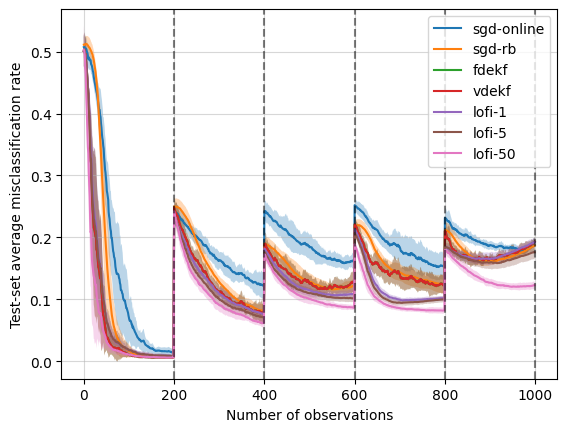

In [165]:
fig, ax = plt.subplots()
for key, val in results.items():
    ax.plot(1.0 - val['overall'], label=key)
    ax.fill_between(
        jnp.arange(val['overall'].shape[0]),
        1.0 - val['overall'] - val['overall-std'],
        1.0 - val['overall'] + val['overall-std'],
        alpha=0.3
    )
# Task boundaries
for b in boundaries:
    ax.axvline(x=b, color='k', linestyle='--', alpha=0.5)
ax.set_xlabel('Number of observations')
ax.set_ylabel('Test-set average misclassification rate');
# ax.set_title(f'Cumulative tasks test-set average misclassification rate')
ax.grid(alpha=0.5)
ax.legend();
fig.savefig(f'{output_path}_{name}.pdf', bbox_inches='tight')

## 11.2 Current Task

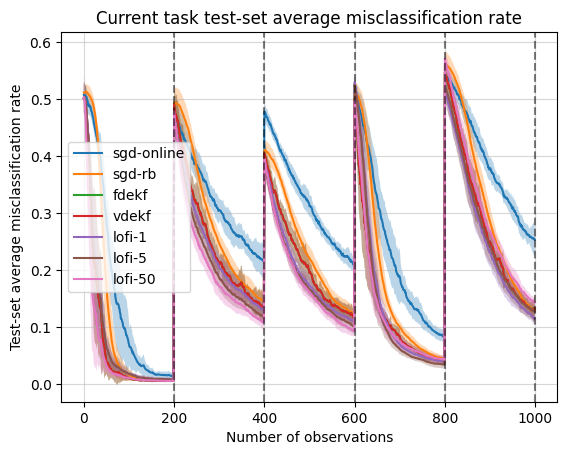

In [164]:
fig, ax = plt.subplots()
for key, val in results.items():
    ax.plot(1.0 - val['current'], label=key)
    ax.fill_between(
        jnp.arange(val['current'].shape[0]),
        1.0 - val['current'] - val['current-std'],
        1.0 - val['current'] + val['current-std'],
        alpha=0.3
    )
# Task boundaries
for b in boundaries:
    ax.axvline(x=b, color='k', linestyle='--', alpha=0.5)
ax.set_xlabel('Number of observations')
ax.set_ylabel('Test-set average misclassification rate');
ax.set_title(f'Current task test-set average misclassification rate')
ax.grid(alpha=0.5)
ax.legend();

## 11.3 Task 1

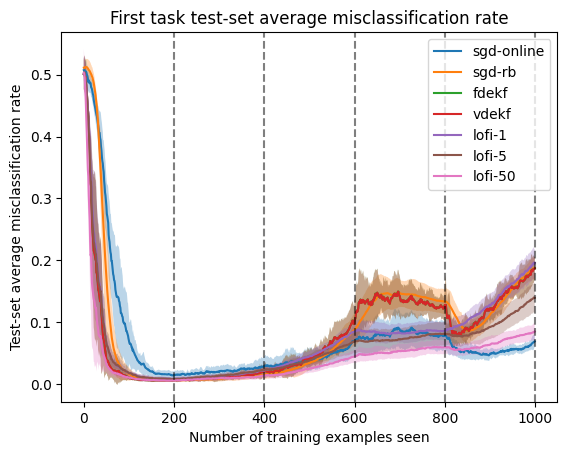

In [157]:
fig, ax = plt.subplots()
for key, val in results.items():
    ax.plot(1.0 - val['task1'], label=key)
    ax.fill_between(
        jnp.arange(val['task1'].shape[0]),
        1.0 - val['task1'] - val['task1-std'],
        1.0 - val['task1'] + val['task1-std'],
        alpha=0.3
    )
# Task boundaries
for b in boundaries:
    ax.axvline(x=b, color='k', linestyle='--', alpha=0.5)
ax.set_xlabel('Number of training examples seen')
ax.set_ylabel('Test-set average misclassification rate');
ax.set_title(f'First task test-set average misclassification rate')
ax.legend();